# Simulations using NFBC1966 results

Using chromosome 1 of the NFBC (Stampeed) data ($n=5340$ samples and $p = 24523$ SNPs), let us simulate:

## Polygenic model

For $r$ traits, our simulation model is:

$$\mathbf{Y}_{r \times n} \sim \text{MatrixNormal}(\mathbf{B}_{r \times p}\mathbf{X}_{p \times n}, \ \ \Sigma_{r \times r} , \ \ \sigma_g^2\Phi_{n \times n} + \sigma_e^2 \mathbf{I}_{n \times n})$$

+ $\mathbf{X}_{p \times n}$ contains *all* predictors (genetic + non-genetic)
+ $\mathbf{B}_{r \times p}$ contains (true) regression coefficients. $k$ entries are non-zero
+ $\Phi$ is the GRM estimated from genotypes
+ $\Sigma_{r \times r}$ is the symmetric PD row (trait) covariance matrix where max condition number is set to 10
+ $\sigma_g^2\Phi_{n \times n} + \sigma_e^2 \mathbf{I}_{n \times n}$ is the column (sample) covariance matrix
+ $\sigma_g^2 = 0.1$ and $\sigma_e^2 = 0.9$ (thus heritability is 10%)
+ $k$ causal SNPs chosen fixed distance with each other across genome
+ $\beta_i:$ every causal SNP affects every phenotype. Causal SNP $i$ have effect size sums up to 0.5 across $r$ traits
+ $r = \{2, 3, 4\}$  (number of traits)
+ $n=5340$ samples
+ $p = 24523$ SNPs
+ q = 5 fold cross validation
+ iterates ≥5 times
+ init_beta=true
+ debias=false

## Sparse model

With $r$ traits, each sample's phenotype $\mathbf{y}_{i} \in \mathbb{R}^{n \times 1}$ is simulated under

$$\mathbf{y}_{i}^{r \times 1} \sim N(\mathbf{B}^{r \times p}\mathbf{x}_{i}^{p \times 1}, \ \ \Sigma_{r \times r})$$

This model assumes each sample is independent.

+ $\mathbf{X}_{p \times n}$ contains *all* predictors (genetic + non-genetic)
+ $\mathbf{B}_{r \times p}$ contains (true) regression coefficients. $k$ entries are non-zero
+ $B_{ij} \in \{0.05, 0.1, ..., 0.5\}$ for $k$ positions
+ $k = \{10, 20, 30\}$ (number of causal SNPs)
+ $\Sigma_{r \times r}$ is the symmetric PD row (trait) covariance matrix where max condition number is set to 10
+ $k = \{10, 20, 30\}$ (number of causal SNPs)
+ $r = \{2, 3, 4\}$  (number of traits)
+ $n=5340$ samples
+ $p = 24523$ SNPs
+ q = 5 fold cross validation
+ iterates ≥5 times
+ init_beta=true
+ debias=false

In [1]:
# some helper functions for summarizing results
using Statistics
using CSV, DataFrames

"""
Find the `nsnps` most significant SNPs for mvPLINK in simulation `sim`.
"""
function get_top_mvPLINK_SNPs(set::Int, sim::Int, nsnps::Int)
    n, p = 5340, 24523
    dir = "set$set/sim$sim/"
    
    # read mvPLINK result
    mvplink_df = CSV.read(dir * "plink.mqfam.total", DataFrame, delim=' ', ignorerepeated=true)

    # get pvalues, possibly accounting for "NA"s
    if eltype(mvplink_df[!, :P]) == Float64
        pval = mvplink_df[!, :P]
    else
        mvplink_df[findall(x -> x == "NA", mvplink_df[!, :P]), :P] .= "1.0"
        pval = parse.(Float64, mvplink_df[!, :P])
    end
    perm = sortperm(pval)
    return perm[1:nsnps]
end

"""
Find the position of the `nsnps` most significant SNPs for GEMMA in simulation `sim`.
"""
function get_top_GEMMA_SNP_ids(set::Int, sim::Int, nsnps::Int)
    dir = "set$set/sim$sim/"
    gemma_df = CSV.read(dir * "gemma.sim$sim.assoc.txt", DataFrame)
    pval_wald = gemma_df[!, :p_wald]
    perm = sortperm(pval_wald)
    return perm[1:nsnps]
end

"""
Find significant SNPs return by IHT in simulation `sim`.
"""
function get_IHT_SNPs(set::Int, sim::Int)
    dir = "set$set/sim$sim/"
    iht_β1 = vec(readdlm(dir * "iht_beta1.txt"))
    iht_β2 = vec(readdlm(dir * "iht_beta2.txt"))
    detected_snps = findall(!iszero, iht_β1) ∪ findall(!iszero, iht_β2)
    return unique(detected_snps)
end

"""
Get positions for the truly causal SNPs in simulation `sim`. 
"""
function get_true_SNPs(set::Int, sim::Int)
    dir = "set$set/sim$sim/"
    trueB = readdlm(dir * "trueb.txt")
    causal_snps = unique([x[1] for x in findall(!iszero, trueB)])
    return causal_snps
end

"""
Get causal SNPs' position in GEMMA's result for simulation `sim`. Note gemma have snp filtering.
"""
function get_gemma_causal_snp_pos(set::Int, sim::Int)
    nfbc = SnpData("NFBC.qc.imputeBy0.chr.1")
    dir = "set$set/sim$sim/"
    trueB = readdlm(dir * "trueb.txt")
    causal_snps = unique([x[1] for x in findall(!iszero, trueB)])
    causal_snp_rsID = nfbc.snp_info.snpid[causal_snps]
    gemma_df = CSV.read(dir * "gemma.sim$sim.assoc.txt", DataFrame)
    gemma_snps = gemma_df[!, :rs]
    causal_snp_idx = convert(Vector{Int}, indexin(causal_snp_rsID, gemma_snps))
    
    # also need IHT's selected SNPs
    iht_snps_rsID = nfbc.snp_info.snpid[get_IHT_SNPs(sim)]
    iht_snps_idx = convert(Vector{Int}, indexin(iht_snps_rsID, gemma_snps))
    
    # also need SNP positions in GEMMA dataframe
    gemma2nfbc_idx = convert(Vector{Int}, indexin(gemma_snps, nfbc.snp_info.snpid))
    gemma_snp_pos = Vector{Int}(undef, size(gemma_df, 1))
    for i in 1:size(gemma_df, 1)
        gemma_snp_pos[i] = nfbc.snp_info.position[gemma2nfbc_idx[i]]
    end
    insertcols!(gemma_df, size(gemma_df, 2) + 1, :pos => gemma_snp_pos)
    
    return gemma_df, causal_snp_idx, iht_snps_idx
end

"""
Imports gemma p-values, causal SNPs, and IHT selected SNP, and plot manhattan plot using MendelPlots.jl
"""
function plot_gemma_manhattan(sim::Int)
    # GEMMA causal SNPs
    gemma_df, causal_snps, iht_snps = get_gemma_causal_snp_pos(sim)
    rename!(gemma_df, [:p_wald => :pval, :rs => :snpid])
    gemma_df[findall(x -> x < 1e-50, gemma_df[!, :pval]), :pval] .= 1e-50
    empty_col = ["" for i in 1:size(gemma_df, 1)]
    insertcols!(gemma_df, size(gemma_df, 2) + 1, :empty_col => empty_col)

    manhattan(gemma_df, outfile = "NFBCsim/manhattan_gemma_sim$sim.png",
        annotateinds = causal_snps, annotateinds2 = iht_snps,
        annotatevar=:empty_col, titles="GEMMA simulation $sim")
    display("image/png", read("NFBCsim/manhattan_gemma_sim$sim.png"))
end

"""
Imports mvPLINK p-values, causal SNPs, and IHT selected SNP, and plot manhattan plot using MendelPlots.jl
"""
function plot_mvPLINK_manhattan(sim::Int)
    # mvPLINK
    filename = "NFBCsim/sim$sim/plink.mqfam.total"
    mvplink_df = CSV.read(filename, DataFrame, delim=' ', ignorerepeated=true)
    if eltype(mvplink_df[!, :P]) == Float64
        pval = mvplink_df[!, :P]
    else
        mvplink_df[findall(x -> x == "NA", mvplink_df[!, :P]), :P] .= "1.0"
        pval = parse.(Float64, mvplink_df[!, :P])
    end
    pval[findall(x -> x < 1e-50, pval)] .= 1e-50 # limit smallest pvalues

    # causal SNPs
    causal_snps = get_true_SNPs(sim)
    
    # IHT SNPs
    iht_snps = get_IHT_SNPs(sim)

    # make dataframe to input into MendelPlots
    snpdata = SnpData("/Users/biona001/Benjamin_Folder/UCLA/research/stampeed/imputed_with_0/NFBC_imputed_with_0")
    rename!(snpdata.snp_info, [:chr, :snpid, :genetic_distance, :pos, :allele1, :allele2])
    insertcols!(snpdata.snp_info, size(snpdata.snp_info, 2) + 1, :pval => pval)
    empty_col = ["" for i in 1:size(snpdata.snp_info, 1)]
    insertcols!(snpdata.snp_info, size(snpdata.snp_info, 2) + 1, :empty_col => empty_col)

    # plot
    manhattan(snpdata.snp_info, outfile = "NFBCsim/manhattan_mvPLINK_sim$sim.png",
        annotateinds = causal_snps, annotateinds2 = iht_snps, 
        annotatevar=:empty_col, titles="mvPLINK simulation $sim")
    display("image/png", read("NFBCsim/manhattan_mvPLINK_sim$sim.png"))
end

"""
Imports mvPLINK p-values and plot QQ plot using MendelPlots.jl
"""
function plot_mvPLINK_QQ(sim::Int)
    filename = "NFBCsim/sim$sim/plink.mqfam.total"
    mvplink_df = CSV.read(filename, DataFrame, delim=' ', ignorerepeated=true)
    if eltype(mvplink_df[!, :P]) == Float64
        pval = mvplink_df[!, :P]
    else
        mvplink_df[findall(x -> x == "NA", mvplink_df[!, :P]), :P] .= "1.0"
        pval = parse.(Float64, mvplink_df[!, :P])
    end
    pval[findall(x -> x < 1e-50, pval)] .= 1e-50 # limit smallest pvalues
    qq(pval, outfile = "NFBCsim/QQ_mvPLINK_sim$sim.png",
        ylabel="mvPLINK observed -log10(p)", titles="mvPLINK simulation $sim")
    display("image/png", read("NFBCsim/QQ_mvPLINK_sim$sim.png"))
end

"""
Imports gemma p-values and plot QQ plot using MendelPlots.jl
"""
function plot_gemma_QQ(sim::Int)
    filename = "NFBCsim/sim$sim/gemma.sim$sim.assoc.txt"
    gemma_df = CSV.read(filename, DataFrame)
    pval_wald = gemma_df[!, :p_wald]
    pval_wald[findall(x -> x < 1e-50, pval_wald)] .= 1e-50 # limit smallest pvalues
    qq(pval_wald, outfile = "NFBCsim/QQ_gemma_sim$sim.png",
        ylabel="GEMMA observed -log10(p)", titles="GEMMA simulation $sim")
    display("image/png", read("NFBCsim/QQ_gemma_sim$sim.png"))
end

# """
# Summarize all simulations for IHT, mvPLINK, GEMMA in computation time, true positives,
# false positives, and false positive rates. 
# """
# function summarize_repeats()
#     model = "NFBCsim"
#     n, p = 5340, 24523
#     sims = 1:50 # k = 10, r = 2, βoverlap=2, polygenic model
#     nfbc = SnpData("/Users/biona001/Benjamin_Folder/UCLA/research/stampeed/imputed_with_0/NFBC_imputed_with_0")
#     snp_rsID = nfbc.snp_info.snpid

#     iht_time, iht_power, iht_FP, iht_FPR = Float64[], Float64[], Float64[], Float64[]
#     mvPLINK_time, mvPLINK_power, mvPLINK_FP, mvPLINK_FPR = Float64[], Float64[], Float64[], Float64[]
#     gemma_time, gemma_power, gemma_FP, gemma_FPR = Float64[], Float64[], Float64[], Float64[]

#     for sim in sims
#         dir = "NFBCsim/sim$sim/"
#         try
#             # correct SNPs
#             trueB = readdlm(dir * "trueb.txt")
#             causal_snps = unique([x[1] for x in findall(!iszero, trueB)])
#             causal_snps_rsID = snp_rsID[causal_snps]

#             # IHT
#             iht_β1 = vec(readdlm(dir * "iht_beta1.txt"))
#             iht_β2 = vec(readdlm(dir * "iht_beta2.txt"))
#             detected_snps = findall(!iszero, iht_β1) ∪ findall(!iszero, iht_β2)
#             ihtpower, ihtFP, ihtFPR = power_and_fpr(p, causal_snps, detected_snps)

#             # MVPLINK
#             plinkpower, plinkFP, plinkFPR = process_mvPLINK(dir * "plink.mqfam.total", causal_snps)

#             # GEMMA 
#             gemmapower, gemmaFP, gemmaFPR = process_gemma_result(dir * "gemma.sim$sim.assoc.txt", causal_snps_rsID)
            
#             push!(iht_power, ihtpower); push!(iht_FP, ihtFP); push!(iht_FPR, ihtFPR); 
#             push!(mvPLINK_power, plinkpower); push!(mvPLINK_FP, plinkFP); push!(mvPLINK_FPR, plinkFPR); 
#             push!(gemma_power, gemmapower); push!(gemma_FP, gemmaFP); push!(gemma_FPR, gemmaFPR);
#         catch
#             println("simulation $sim failed!")
#         end
#     end

#     return iht_time, iht_power, iht_FP, iht_FPR,
#         mvPLINK_time, mvPLINK_power, mvPLINK_FP, mvPLINK_FPR,
#         gemma_time, gemma_power, gemma_FP, gemma_FPR
# end

"""
For each simulation set, after performing n simulations using `run_repeats`,
this function reads the summary files for each simulation and summarizes the result. 
The final summary is saved in the variable `simdir` (directory which includes
the simulation scripts)
"""
function read_summary(ld::Float64; verbose=true)    
    ld ∈ [0.25, 0.5, 0.75, 1.0] || error("ld should be 0.25, 0.5, 0.75, 1.0")
    
    mIHT_time, mIHT_plei_power, mIHT_indp_power, mIHT_FP, mIHT_FPR = 
        Float64[], Float64[], Float64[], Float64[], Float64[]
    uIHT_time, uIHT_plei_power, uIHT_indp_power, uIHT_FP, uIHT_FPR = 
        Float64[], Float64[], Float64[], Float64[], Float64[]
    mvPLINK_time, mvPLINK_plei_power, mvPLINK_indp_power, mvPLINK_FP, 
        mvPLINK_FPR, mvPLINK_λ = Float64[], Float64[], Float64[], Float64[], Float64[], Float64[]
    gemma_time, gemma_plei_power, gemma_indp_power, gemma_FP, gemma_FPR, gemma_λ = 
        Float64[], Float64[], Float64[], Float64[], Float64[], Float64[]

    # compute summary statistics
    simdir = "/scratch/users/bbchu/NFBC_sim"
    open(joinpath(simdir, "summary_LD$(ld).txt"), "w") do summary_io
        for set in 1:4
            empty!(mIHT_time); empty!(mIHT_plei_power); empty!(mIHT_indp_power); empty!(mIHT_FP); empty!(mIHT_FPR)
            empty!(uIHT_time); empty!(uIHT_plei_power); empty!(uIHT_indp_power); empty!(uIHT_FP); empty!(uIHT_FPR)
            empty!(mvPLINK_time); empty!(mvPLINK_plei_power); empty!(mvPLINK_indp_power); empty!(mvPLINK_FP); empty!(mvPLINK_FPR); empty!(mvPLINK_λ)
            empty!(gemma_time); empty!(gemma_plei_power); empty!(gemma_indp_power); empty!(gemma_FP); empty!(gemma_FPR); empty!(gemma_λ)

            # read each simulation's result
            for sim in 1:100
                sim_result = joinpath(simdir, "set$(set)_LD$(ld)/sim$sim/summary.txt")
                isfile(sim_result) && countlines(sim_result) > 0 || continue
                df = CSV.read(sim_result, DataFrame)
                methods = df[!, "method"]

                # parse mIHT result
                idx = findfirst(x -> x == "mIHT", methods)
                if !isnothing(idx)
                    mIHT = df[idx, :]
                    push!(mIHT_time, mIHT["time"])
                    push!(mIHT_plei_power, mIHT["plei_power"])
                    push!(mIHT_indp_power, mIHT["indep_power"])
                    push!(mIHT_FP, mIHT["FP"])
                    push!(mIHT_FPR, mIHT["FRP"]) # this is a typo, should be FPR
                end
                
                # parse uIHT result
                idx = findfirst(x -> x == "uIHT", methods)
                if !isnothing(idx)
                    uIHT = df[idx, :]
                    push!(uIHT_time, uIHT["time"])
                    push!(uIHT_plei_power, uIHT["plei_power"])
                    push!(uIHT_indp_power, uIHT["indep_power"])
                    push!(uIHT_FP, uIHT["FP"])
                    push!(uIHT_FPR, uIHT["FRP"]) # this is a typo, should be FPR
                end
                
                # parse mvPLINK result
                idx = findfirst(x -> x == "mvPLINK", methods)
                if !isnothing(idx)
                    mvPLINK = df[idx, :]
                    push!(mvPLINK_time, mvPLINK["time"])
                    push!(mvPLINK_plei_power, mvPLINK["plei_power"])
                    push!(mvPLINK_indp_power, mvPLINK["indep_power"])
                    push!(mvPLINK_FP, mvPLINK["FP"])
                    push!(mvPLINK_FPR, mvPLINK["FRP"]) # this is a typo, should be FPR
                    push!(mvPLINK_λ, mvPLINK["λ"])
                end

                # parse gemma result
                idx = findfirst(x -> x == "gemma", methods)
                if !isnothing(idx)
                    gemma = df[idx, :]
                    push!(gemma_time, gemma["time"])
                    push!(gemma_plei_power, gemma["plei_power"])
                    push!(gemma_indp_power, gemma["indep_power"])
                    push!(gemma_FP, gemma["FP"])
                    push!(gemma_FPR, gemma["FRP"]) # this is a typo, should be FPR
                    push!(gemma_λ, gemma["λ"])
                end
            end
                        
            # summary statistics
            mIHT_time_mean, mIHT_time_std = round(mean(mIHT_time), digits=1), round(std(mIHT_time), digits=1)
            mIHT_plei_TP_mean, mIHT_plei_TP_std = round(mean(mIHT_plei_power), digits=2), round(std(mIHT_plei_power), digits=2)
            mIHT_indp_TP_mean, mIHT_indp_TP_std = round(mean(mIHT_indp_power), digits=2), round(std(mIHT_indp_power), digits=2)
            mIHT_FP_mean, mIHT_FP_std = round(mean(mIHT_FP), digits=1), round(std(mIHT_FP), digits=1)
            
            uIHT_time_mean, uIHT_time_std = round(mean(uIHT_time), digits=1), round(std(uIHT_time), digits=1)
            uIHT_plei_TP_mean, uIHT_plei_TP_std = round(mean(uIHT_plei_power), digits=2), round(std(uIHT_plei_power), digits=2)
            uIHT_indp_TP_mean, uIHT_indp_TP_std = round(mean(uIHT_indp_power), digits=2), round(std(uIHT_indp_power), digits=2)
            uIHT_FP_mean, uIHT_FP_std = round(mean(uIHT_FP), digits=1), round(std(uIHT_FP), digits=1)
            
            mvPLINK_time_mean, mvPLINK_time_std = round(mean(mvPLINK_time), digits=1), round(std(mvPLINK_time), digits=1)
            mvPLINK_plei_TP_mean, mvPLINK_plei_TP_std = round(mean(mvPLINK_plei_power), digits=2), round(std(mvPLINK_plei_power), digits=2)
            mvPLINK_indp_TP_mean, mvPLINK_indp_TP_std = round(mean(mvPLINK_indp_power), digits=2), round(std(mvPLINK_indp_power), digits=2)
            mvPLINK_FP_mean, mvPLINK_FP_std = round(mean(mvPLINK_FP), digits=1), round(std(mvPLINK_FP), digits=1)
            mvPLINK_λ_mean, mvPLINK_λ_std = round(mean(mvPLINK_λ), digits=1), round(std(mvPLINK_λ), digits=1)
            
            gemma_time_mean, gemma_time_std = round(mean(gemma_time), digits=1), round(std(gemma_time), digits=1)
            gemma_plei_TP_mean, gemma_plei_TP_std = round(mean(gemma_plei_power), digits=2), round(std(gemma_plei_power), digits=2)
            gemma_indp_TP_mean, gemma_indp_TP_std = round(mean(gemma_indp_power), digits=2), round(std(gemma_indp_power), digits=2)
            gemma_FP_mean, gemma_FP_std = round(mean(gemma_FP), digits=1), round(std(gemma_FP), digits=1)
            gemma_λ_mean, gemma_λ_std = round(mean(gemma_λ), digits=1), round(std(gemma_λ), digits=1)
            
            println(summary_io, "set $set (LD $ld) summary:")
            println(summary_io, "mIHT success = $(length(mIHT_time)), time = $mIHT_time_mean ± $mIHT_time_std, plei TP = $mIHT_plei_TP_mean ± $mIHT_plei_TP_std, indep TP = $mIHT_indp_TP_mean ± $mIHT_indp_TP_std, FP = $mIHT_FP_mean ± $mIHT_FP_std")
            println(summary_io, "uIHT success = $(length(uIHT_time)), time = $uIHT_time_mean ± $uIHT_time_std, plei TP = $uIHT_plei_TP_mean ± $uIHT_plei_TP_std, indep TP = $uIHT_indp_TP_mean ± $uIHT_indp_TP_std, FP = $uIHT_FP_mean ± $uIHT_FP_std")
            println(summary_io, "mvPLINK success = $(length(mvPLINK_time)), time = $mvPLINK_time_mean ± $mvPLINK_time_std, plei TP = $mvPLINK_plei_TP_mean ± $mvPLINK_plei_TP_std, indep TP = $mvPLINK_indp_TP_mean ± $mvPLINK_indp_TP_std, FP = $mvPLINK_FP_mean ± $mvPLINK_FP_std")
            println(summary_io, "gemma success = $(length(gemma_time)), time = $gemma_time_mean ± $gemma_time_std, plei TP = $gemma_plei_TP_mean ± $gemma_plei_TP_std, indep TP = $gemma_indp_TP_mean ± $gemma_indp_TP_std, FP = $gemma_FP_mean ± $gemma_FP_std \n")
            
            if verbose
                println("set $set (LD $ld) summary:")
                println("mIHT success = $(length(mIHT_time)), time = $mIHT_time_mean ± $mIHT_time_std, plei TP = $mIHT_plei_TP_mean ± $mIHT_plei_TP_std, indep TP = $mIHT_indp_TP_mean ± $mIHT_indp_TP_std, FP = $mIHT_FP_mean ± $mIHT_FP_std")
                println("uIHT success = $(length(uIHT_time)), time = $uIHT_time_mean ± $uIHT_time_std, plei TP = $uIHT_plei_TP_mean ± $uIHT_plei_TP_std, indep TP = $uIHT_indp_TP_mean ± $uIHT_indp_TP_std, FP = $uIHT_FP_mean ± $uIHT_FP_std")
                println("mvPLINK success = $(length(mvPLINK_time)), time = $mvPLINK_time_mean ± $mvPLINK_time_std, plei TP = $mvPLINK_plei_TP_mean ± $mvPLINK_plei_TP_std, indep TP = $mvPLINK_indp_TP_mean ± $mvPLINK_indp_TP_std, FP = $mvPLINK_FP_mean ± $mvPLINK_FP_std")
                println("gemma success = $(length(gemma_time)), time = $gemma_time_mean ± $gemma_time_std, plei TP = $gemma_plei_TP_mean ± $gemma_plei_TP_std, indep TP = $gemma_indp_TP_mean ± $gemma_indp_TP_std, FP = $gemma_FP_mean ± $gemma_FP_std \n")
            end
            
            # for latex table
#             if verbose
#                 println("set $set summary:")
#                 println("\\texttt{mIHT} & \$$mIHT_time_mean \\pm $mIHT_time_std\$ & \$$mIHT_plei_TP_mean \\pm $mIHT_plei_TP_std\$ & \$$mIHT_indp_TP_mean \\pm $mIHT_indp_TP_std\$ & \$$mIHT_FP_mean \\pm $mIHT_FP_std\$\\\\")
#                 println("\\texttt{uIHT} & \$$uIHT_time_mean \\pm $uIHT_time_std\$ & \$$uIHT_plei_TP_mean \\pm $uIHT_plei_TP_std\$ & \$$uIHT_indp_TP_mean \\pm $uIHT_indp_TP_std\$ & \$$uIHT_FP_mean \\pm $uIHT_FP_std\$\\\\")
#                 println("\\texttt{CCA} & \$$mvPLINK_time_mean \\pm $mvPLINK_time_std\$ & \$$mvPLINK_plei_TP_mean \\pm $mvPLINK_plei_TP_std\$ & \$$mvPLINK_indp_TP_mean \\pm $mvPLINK_indp_TP_std\$ & \$$mvPLINK_FP_mean \\pm $mvPLINK_FP_std\$\\\\")
#                 println("\\texttt{mvLMM} & \$$gemma_time_mean \\pm $gemma_time_std\$ & \$$gemma_plei_TP_mean \\pm $gemma_plei_TP_std\$ & \$$gemma_indp_TP_mean \\pm $gemma_indp_TP_std\$ & \$$gemma_FP_mean \\pm $gemma_FP_std\$\\\\ \n")
#             end
        end
    end
    
    return nothing
end

read_summary

# With LD filtering

In [13]:
ld = 0.25
read_summary(ld)

set 1 (LD 0.25) summary:
mIHT success = 99, time = 12.8 ± 5.9, plei TP = 0.96 ± 0.11, indep TP = 0.8 ± 0.21, FP = 0.3 ± 1.1
uIHT success = 99, time = 12.1 ± 4.5, plei TP = 0.96 ± 0.11, indep TP = 0.79 ± 0.21, FP = 0.1 ± 0.3
mvPLINK success = 99, time = 29.9 ± 6.7, plei TP = 0.97 ± 0.09, indep TP = 0.79 ± 0.21, FP = 11.8 ± 8.0
gemma success = 99, time = 93.5 ± 13.1, plei TP = 0.97 ± 0.1, indep TP = 0.77 ± 0.22, FP = 5.1 ± 3.0 

set 2 (LD 0.25) summary:
mIHT success = 97, time = 17.7 ± 4.9, plei TP = 0.95 ± 0.09, indep TP = 0.82 ± 0.13, FP = 0.5 ± 0.9
uIHT success = 97, time = 20.3 ± 4.0, plei TP = 0.95 ± 0.1, indep TP = 0.78 ± 0.14, FP = 0.2 ± 0.6
mvPLINK success = 97, time = 52.0 ± 2.6, plei TP = 0.95 ± 0.09, indep TP = 0.77 ± 0.13, FP = 19.5 ± 10.2
gemma success = 97, time = 108.6 ± 12.9, plei TP = 0.94 ± 0.1, indep TP = 0.74 ± 0.14, FP = 7.2 ± 3.4 

set 3 (LD 0.25) summary:
mIHT success = 100, time = 30.3 ± 8.8, plei TP = 0.97 ± 0.07, indep TP = 0.8 ± 0.1, FP = 0.9 ± 1.8
uIHT success

In [14]:
ld = 0.5
read_summary(ld)

set 1 (LD 0.5) summary:
mIHT success = 99, time = 20.8 ± 7.8, plei TP = 0.96 ± 0.11, indep TP = 0.79 ± 0.2, FP = 0.5 ± 1.2
uIHT success = 99, time = 17.6 ± 6.9, plei TP = 0.96 ± 0.11, indep TP = 0.79 ± 0.19, FP = 0.1 ± 0.4
mvPLINK success = 99, time = 54.1 ± 8.9, plei TP = 0.96 ± 0.11, indep TP = 0.79 ± 0.2, FP = 26.7 ± 14.3
gemma success = 99, time = 113.1 ± 13.6, plei TP = 0.96 ± 0.11, indep TP = 0.77 ± 0.2, FP = 16.5 ± 7.7 

set 2 (LD 0.5) summary:
mIHT success = 95, time = 35.0 ± 12.1, plei TP = 0.95 ± 0.1, indep TP = 0.79 ± 0.14, FP = 1.2 ± 3.0
uIHT success = 95, time = 34.0 ± 8.7, plei TP = 0.95 ± 0.1, indep TP = 0.76 ± 0.14, FP = 0.4 ± 0.7
mvPLINK success = 95, time = 90.0 ± 11.3, plei TP = 0.95 ± 0.1, indep TP = 0.77 ± 0.14, FP = 47.1 ± 20.4
gemma success = 95, time = 163.0 ± 20.4, plei TP = 0.95 ± 0.1, indep TP = 0.74 ± 0.14, FP = 27.2 ± 11.2 

set 3 (LD 0.5) summary:
mIHT success = 100, time = 52.2 ± 15.8, plei TP = 0.96 ± 0.07, indep TP = 0.8 ± 0.11, FP = 2.0 ± 3.4
uIHT succ

In [15]:
ld = 0.75
read_summary(ld)

set 1 (LD 0.75) summary:
mIHT success = 100, time = 31.8 ± 11.5, plei TP = 0.97 ± 0.09, indep TP = 0.78 ± 0.21, FP = 1.1 ± 2.7
uIHT success = 100, time = 25.1 ± 3.7, plei TP = 0.96 ± 0.11, indep TP = 0.78 ± 0.21, FP = 0.2 ± 0.5
mvPLINK success = 100, time = 77.1 ± 3.7, plei TP = 0.97 ± 0.09, indep TP = 0.78 ± 0.21, FP = 41.2 ± 23.0
gemma success = 100, time = 139.9 ± 4.0, plei TP = 0.97 ± 0.09, indep TP = 0.76 ± 0.21, FP = 27.0 ± 13.6 

set 2 (LD 0.75) summary:
mIHT success = 97, time = 51.7 ± 18.6, plei TP = 0.95 ± 0.09, indep TP = 0.79 ± 0.13, FP = 2.6 ± 5.4
uIHT success = 97, time = 50.9 ± 14.1, plei TP = 0.94 ± 0.11, indep TP = 0.76 ± 0.13, FP = 0.3 ± 0.6
mvPLINK success = 97, time = 131.1 ± 10.5, plei TP = 0.95 ± 0.09, indep TP = 0.77 ± 0.13, FP = 77.4 ± 32.5
gemma success = 97, time = 220.7 ± 27.7, plei TP = 0.95 ± 0.09, indep TP = 0.74 ± 0.14, FP = 49.3 ± 18.0 

set 3 (LD 0.75) summary:
mIHT success = 100, time = 82.5 ± 23.8, plei TP = 0.96 ± 0.09, indep TP = 0.78 ± 0.12, FP = 2

# Make plot for LD filtering

In [2]:
using Plots
gr(fmt=:png)

function summary_set(set::Int, ld::Float64; verbose=true)
    set ∈ [1,2,3,4,5,6] || error("set should be 1,2,3,4,5, or 6")
    ld ∈ [0.25, 0.5, 0.75, 1.0] || error("ld should be 0.25, 0.5, 0.75, or 1.0")
    
    mIHT_time, mIHT_plei_power, mIHT_indp_power, mIHT_FP, mIHT_FPR = 
        Float64[], Float64[], Float64[], Float64[], Float64[]
    uIHT_time, uIHT_plei_power, uIHT_indp_power, uIHT_FP, uIHT_FPR = 
        Float64[], Float64[], Float64[], Float64[], Float64[]
    mvPLINK_time, mvPLINK_plei_power, mvPLINK_indp_power, mvPLINK_FP, 
        mvPLINK_FPR, mvPLINK_λ = Float64[], Float64[], Float64[], Float64[], Float64[], Float64[]
    gemma_time, gemma_plei_power, gemma_indp_power, gemma_FP, gemma_FPR, gemma_λ = 
        Float64[], Float64[], Float64[], Float64[], Float64[], Float64[]

    # compute summary statistics
    simdir = "/scratch/users/bbchu/NFBC_sim"

    # read each simulation's result
    for sim in 1:100
        sim_result = joinpath(simdir, "set$(set)_LD$(ld)/sim$sim/summary.txt")
        isfile(sim_result) || continue
        df = CSV.read(sim_result, DataFrame)
        methods = df[!, "method"]

        # parse mIHT result
        idx = findfirst(x -> x == "mIHT", methods)
        if !isnothing(idx)
            mIHT = df[idx, :]
            push!(mIHT_time, mIHT["time"])
            push!(mIHT_plei_power, mIHT["plei_power"])
            push!(mIHT_indp_power, mIHT["indep_power"])
            push!(mIHT_FP, mIHT["FP"])
            push!(mIHT_FPR, mIHT["FRP"]) # this is a typo, should be FPR
        end

        # parse uIHT result
        idx = findfirst(x -> x == "uIHT", methods)
        if !isnothing(idx)
            uIHT = df[idx, :]
            push!(uIHT_time, uIHT["time"])
            push!(uIHT_plei_power, uIHT["plei_power"])
            push!(uIHT_indp_power, uIHT["indep_power"])
            push!(uIHT_FP, uIHT["FP"])
            push!(uIHT_FPR, uIHT["FRP"]) # this is a typo, should be FPR
        end

        # parse mvPLINK result
        idx = findfirst(x -> x == "mvPLINK", methods)
        if !isnothing(idx)
            mvPLINK = df[idx, :]
            push!(mvPLINK_time, mvPLINK["time"])
            push!(mvPLINK_plei_power, mvPLINK["plei_power"])
            push!(mvPLINK_indp_power, mvPLINK["indep_power"])
            push!(mvPLINK_FP, mvPLINK["FP"])
            push!(mvPLINK_FPR, mvPLINK["FRP"]) # this is a typo, should be FPR
            push!(mvPLINK_λ, mvPLINK["λ"])
        end

        # parse gemma result
        idx = findfirst(x -> x == "gemma", methods)
        if !isnothing(idx)
            gemma = df[idx, :]
            push!(gemma_time, gemma["time"])
            push!(gemma_plei_power, gemma["plei_power"])
            push!(gemma_indp_power, gemma["indep_power"])
            push!(gemma_FP, gemma["FP"])
            push!(gemma_FPR, gemma["FRP"]) # this is a typo, should be FPR
            push!(gemma_λ, gemma["λ"])
        end
    end
                        
    # summary statistics
    mIHT_time_mean, mIHT_time_std = round(mean(mIHT_time), digits=10), round(std(mIHT_time), digits=10)
    mIHT_plei_TP_mean, mIHT_plei_TP_std = round(mean(mIHT_plei_power), digits=10), round(std(mIHT_plei_power), digits=10)
    mIHT_indp_TP_mean, mIHT_indp_TP_std = round(mean(mIHT_indp_power), digits=10), round(std(mIHT_indp_power), digits=10)
    mIHT_FP_mean, mIHT_FP_std = round(mean(mIHT_FP), digits=10), round(std(mIHT_FP), digits=10)

    uIHT_time_mean, uIHT_time_std = round(mean(uIHT_time), digits=10), round(std(uIHT_time), digits=10)
    uIHT_plei_TP_mean, uIHT_plei_TP_std = round(mean(uIHT_plei_power), digits=10), round(std(uIHT_plei_power), digits=10)
    uIHT_indp_TP_mean, uIHT_indp_TP_std = round(mean(uIHT_indp_power), digits=10), round(std(uIHT_indp_power), digits=10)
    uIHT_FP_mean, uIHT_FP_std = round(mean(uIHT_FP), digits=10), round(std(uIHT_FP), digits=10)

    mvPLINK_time_mean, mvPLINK_time_std = round(mean(mvPLINK_time), digits=10), round(std(mvPLINK_time), digits=10)
    mvPLINK_plei_TP_mean, mvPLINK_plei_TP_std = round(mean(mvPLINK_plei_power), digits=10), round(std(mvPLINK_plei_power), digits=10)
    mvPLINK_indp_TP_mean, mvPLINK_indp_TP_std = round(mean(mvPLINK_indp_power), digits=10), round(std(mvPLINK_indp_power), digits=10)
    mvPLINK_FP_mean, mvPLINK_FP_std = round(mean(mvPLINK_FP), digits=10), round(std(mvPLINK_FP), digits=10)
    mvPLINK_λ_mean, mvPLINK_λ_std = round(mean(mvPLINK_λ), digits=10), round(std(mvPLINK_λ), digits=10)

    gemma_time_mean, gemma_time_std = round(mean(gemma_time), digits=10), round(std(gemma_time), digits=10)
    gemma_plei_TP_mean, gemma_plei_TP_std = round(mean(gemma_plei_power), digits=10), round(std(gemma_plei_power), digits=10)
    gemma_indp_TP_mean, gemma_indp_TP_std = round(mean(gemma_indp_power), digits=10), round(std(gemma_indp_power), digits=10)
    gemma_FP_mean, gemma_FP_std = round(mean(gemma_FP), digits=10), round(std(gemma_FP), digits=10)
    gemma_λ_mean, gemma_λ_std = round(mean(gemma_λ), digits=10), round(std(gemma_λ), digits=10)

    if verbose
        println("set $set (LD $ld) summary:")
        println("mIHT success = $(length(mIHT_time)), time = $mIHT_time_mean ± $mIHT_time_std, plei TP = $mIHT_plei_TP_mean ± $mIHT_plei_TP_std, indep TP = $mIHT_indp_TP_mean ± $mIHT_indp_TP_std, FP = $mIHT_FP_mean ± $mIHT_FP_std")
        println("uIHT success = $(length(uIHT_time)), time = $uIHT_time_mean ± $uIHT_time_std, plei TP = $uIHT_plei_TP_mean ± $uIHT_plei_TP_std, indep TP = $uIHT_indp_TP_mean ± $uIHT_indp_TP_std, FP = $uIHT_FP_mean ± $uIHT_FP_std")
        println("mvPLINK success = $(length(mvPLINK_time)), time = $mvPLINK_time_mean ± $mvPLINK_time_std, plei TP = $mvPLINK_plei_TP_mean ± $mvPLINK_plei_TP_std, indep TP = $mvPLINK_indp_TP_mean ± $mvPLINK_indp_TP_std, FP = $mvPLINK_FP_mean ± $mvPLINK_FP_std")
        println("gemma success = $(length(gemma_time)), time = $gemma_time_mean ± $gemma_time_std, plei TP = $gemma_plei_TP_mean ± $gemma_plei_TP_std, indep TP = $gemma_indp_TP_mean ± $gemma_indp_TP_std, FP = $gemma_FP_mean ± $gemma_FP_std \n")
    end
    
    return mIHT_time_mean, mIHT_plei_TP_mean, mIHT_indp_TP_mean, mIHT_FP_mean, 
        uIHT_time_mean, uIHT_plei_TP_mean, uIHT_indp_TP_mean, uIHT_FP_mean, 
        mvPLINK_time_mean, mvPLINK_plei_TP_mean, mvPLINK_indp_TP_mean, mvPLINK_FP_mean, 
        gemma_time_mean, gemma_plei_TP_mean, gemma_indp_TP_mean, gemma_FP_mean
end

summary_set (generic function with 1 method)

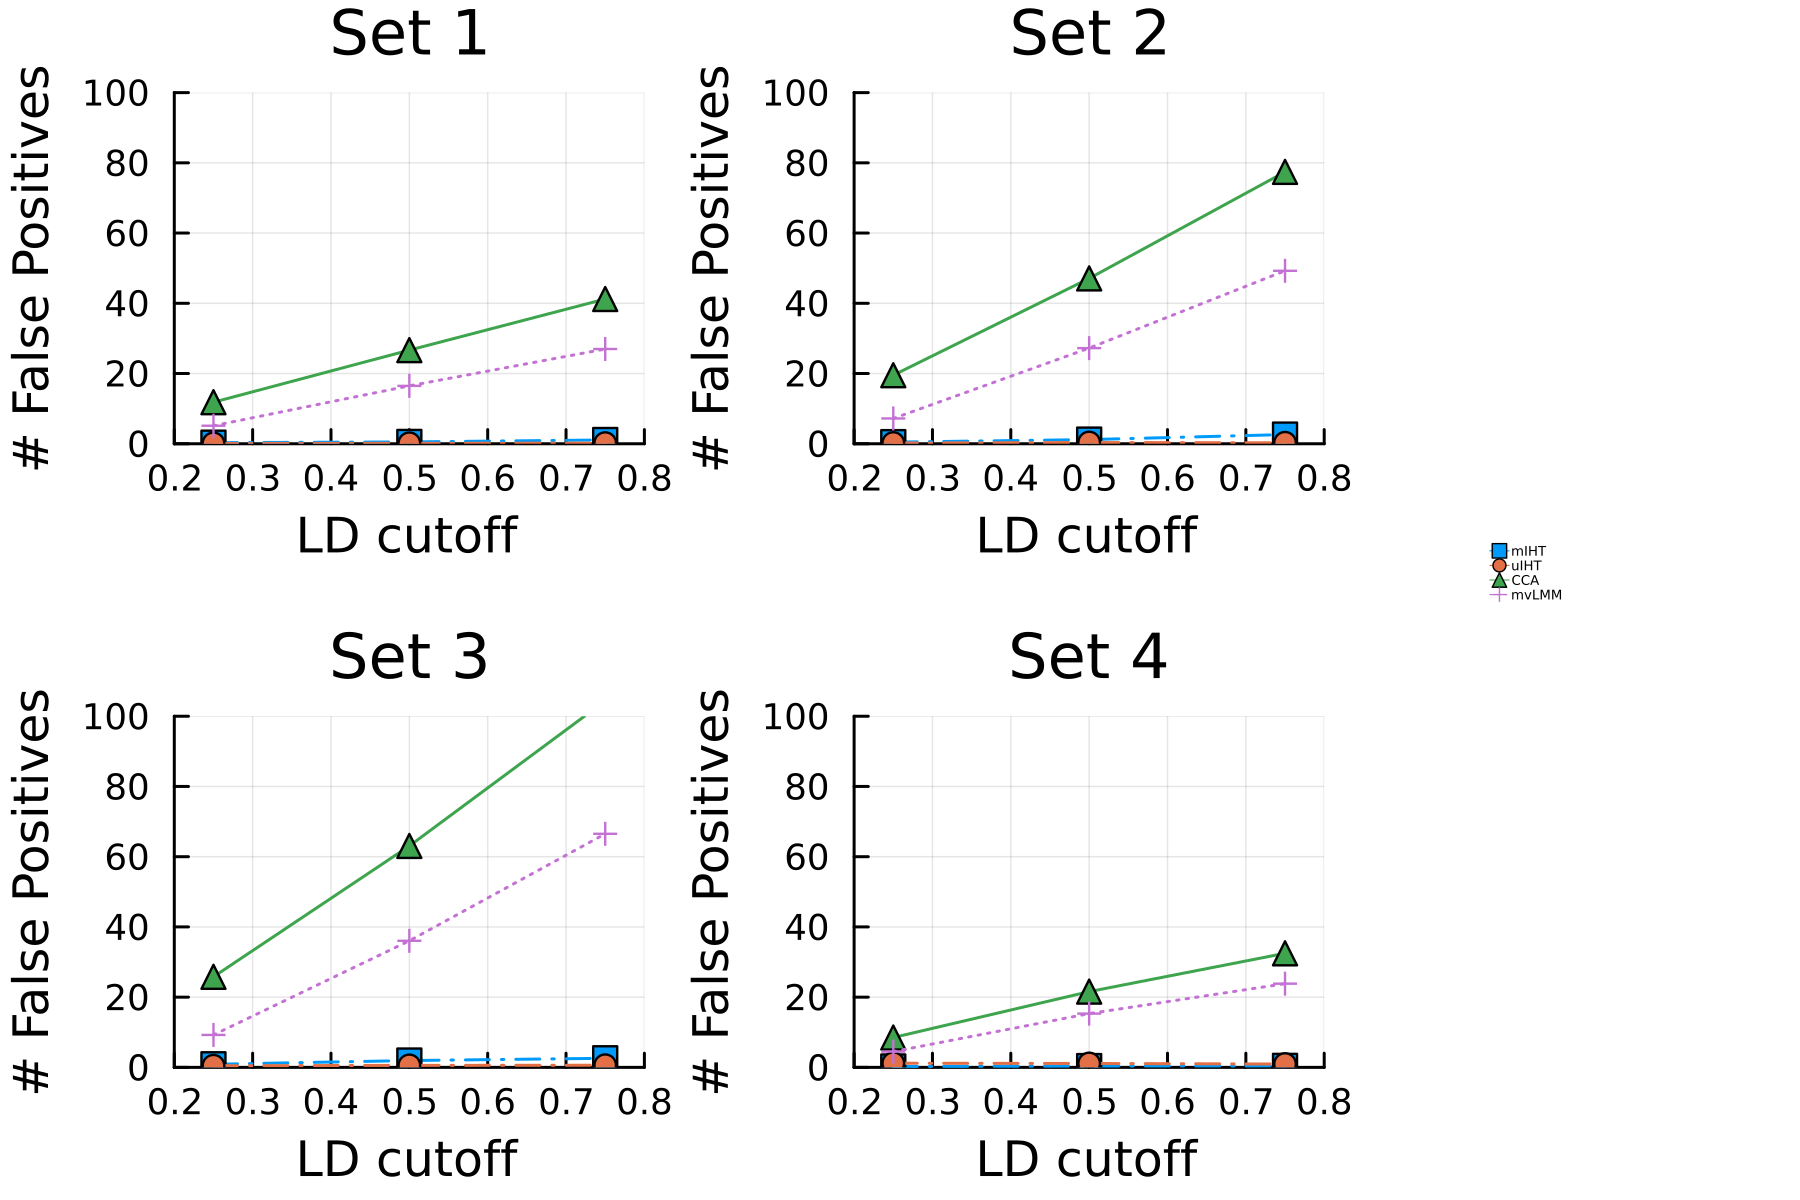

In [4]:
plts = []
LDs = collect(0.25:0.25:0.75)
set_1_and_2_args = (xlim=(0.2, 0.8), ylim=(0, 100), 
    legend=false, ylabel="# False Positives", xlabel="LD cutoff", 
    bottommargin=5Plots.mm)
set_3_and_4_args = (xlim=(0.2, 0.8), ylim=(0, 100),
    legend=false, ylabel="# False Positives", xlabel="LD cutoff")
for set in 1:4
    mIHT_time, mIHT_plei_power, mIHT_indp_power, mIHT_FP, mIHT_FPR = 
        Float64[], Float64[], Float64[], Float64[], Float64[]
    uIHT_time, uIHT_plei_power, uIHT_indp_power, uIHT_FP, uIHT_FPR = 
        Float64[], Float64[], Float64[], Float64[], Float64[]
    mvPLINK_time, mvPLINK_plei_power, mvPLINK_indp_power, mvPLINK_FP, 
        mvPLINK_FPR, mvPLINK_λ = Float64[], Float64[], Float64[], Float64[], Float64[], Float64[]
    gemma_time, gemma_plei_power, gemma_indp_power, gemma_FP, gemma_FPR, gemma_λ = 
        Float64[], Float64[], Float64[], Float64[], Float64[], Float64[]

    for ld in LDs
        # first obtain mean for current LD
        mIHT_time_mean, mIHT_plei_TP_mean, mIHT_indp_TP_mean, mIHT_FP_mean, 
            uIHT_time_mean, uIHT_plei_TP_mean, uIHT_indp_TP_mean, uIHT_FP_mean, 
            mvPLINK_time_mean, mvPLINK_plei_TP_mean, mvPLINK_indp_TP_mean, mvPLINK_FP_mean, 
            gemma_time_mean, gemma_plei_TP_mean, gemma_indp_TP_mean, gemma_FP_mean = 
            summary_set(set, ld, verbose=false)

        # save the mean values
        push!(mIHT_time, mIHT_time_mean)
        push!(mIHT_plei_power, mIHT_plei_TP_mean)
        push!(mIHT_indp_power, mIHT_indp_TP_mean)
        push!(mIHT_FP, mIHT_FP_mean)

        push!(uIHT_time, uIHT_time_mean)
        push!(uIHT_plei_power, uIHT_plei_TP_mean)
        push!(uIHT_indp_power, uIHT_indp_TP_mean)
        push!(uIHT_FP, uIHT_FP_mean)

        push!(mvPLINK_time, mvPLINK_time_mean)
        push!(mvPLINK_plei_power, mvPLINK_plei_TP_mean)
        push!(mvPLINK_indp_power, mvPLINK_indp_TP_mean)
        push!(mvPLINK_FP, mvPLINK_FP_mean)

        push!(gemma_time, gemma_time_mean)
        push!(gemma_plei_power, gemma_plei_TP_mean)
        push!(gemma_indp_power, gemma_indp_TP_mean)
        push!(gemma_FP, gemma_FP_mean)
    end

    FP_plt = set ≤ 2 ? 
        plot(;title="Set $set", set_1_and_2_args...) : 
        plot(;title="Set $set", set_3_and_4_args...)
    plot!(FP_plt, LDs, mIHT_FP, label="mIHT", markershape=:rect, linestyle=:dashdot)
    plot!(FP_plt, LDs, uIHT_FP, label="uIHT", markershape=:circle, linestyle=:dashdot)
    plot!(FP_plt, LDs, mvPLINK_FP, label="CCA", markershape=:utriangle, linestyle=:solid)
    plot!(FP_plt, LDs, gemma_FP, label="mvLMM", markershape=:cross, linestyle=:dot)
    push!(plts, FP_plt)
end

# make separate plot for legend
n = 4
colors = palette(:default)[1:n]'
labels = ["mIHT" "uIHT" "CCA" "mvLMM"]
shapes = [:rect :circle :utriangle :cross]
lstyles = [:dashdot :dashdot :solid :dot]
legend_plt = plot((-n:-1)',(-n:-1)', lims=(0,1), legendfontsize=3, legend=:left,
    fg_color_legend = nothing, label=labels, fc=colors, frame=:none, 
    markershapes=shapes, linestyle=lstyles)

# create 2x2 and legend layout
l = @layout [grid(2,2) a{0.2w}]
plot(plts..., legend_plt, layout=l, dpi=300)

Note: We need to make a separate plot (below) that includes only legend because the legend in plot above is really ugly and there is appararently NO WAY of adjusting legend padding. 

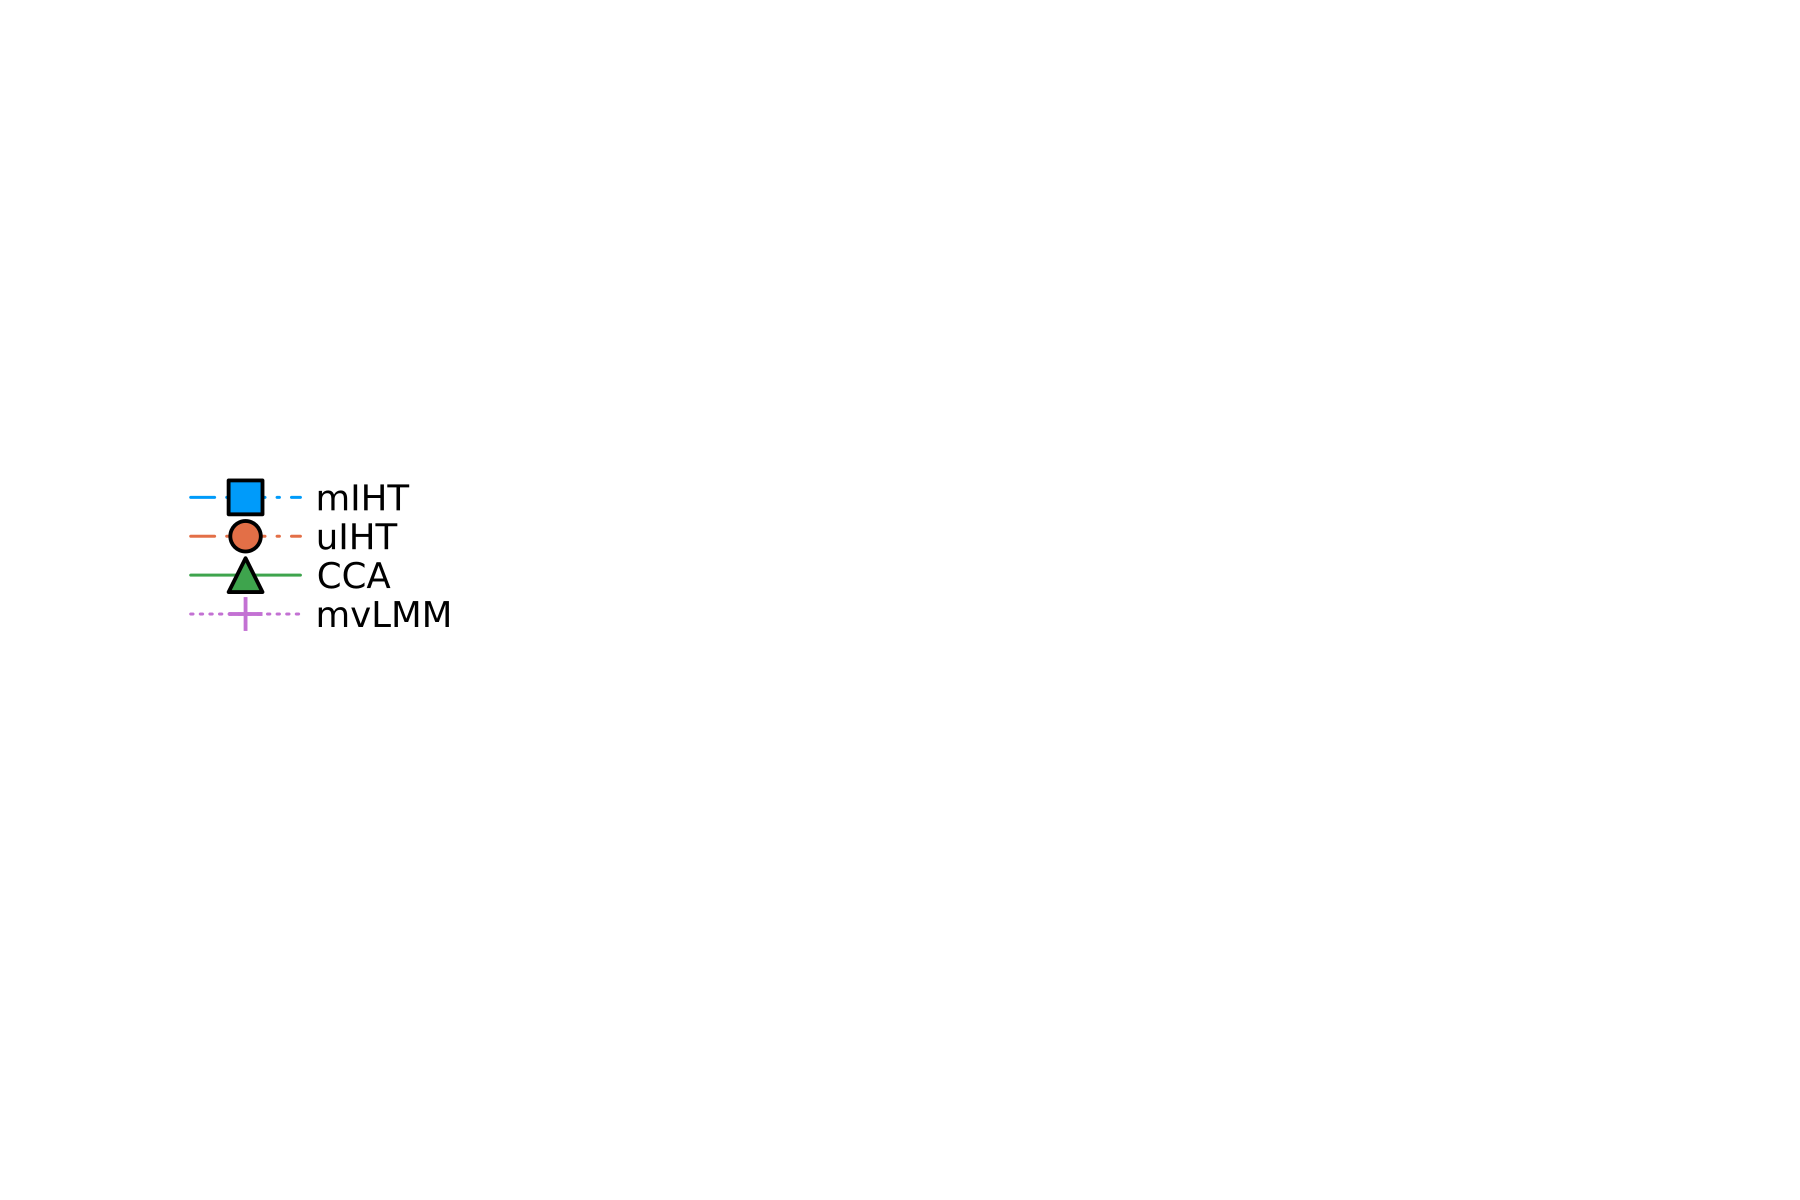

In [5]:
n = 4
colors = palette(:default)[1:n]'
labels = ["mIHT" "uIHT" "CCA" "mvLMM"]
shapes = [:rect :circle :utriangle :cross]
lstyles = [:dashdot :dashdot :solid :dot]
legend_plt = plot((-n:-1)',(-n:-1)', lims=(0,1), legendfontsize=8, legend=:left,
    fg_color_legend = nothing, label=labels, fc=colors, frame=:none, 
    markershapes=shapes, linestyle=lstyles, dpi=300)

## Plei power plot

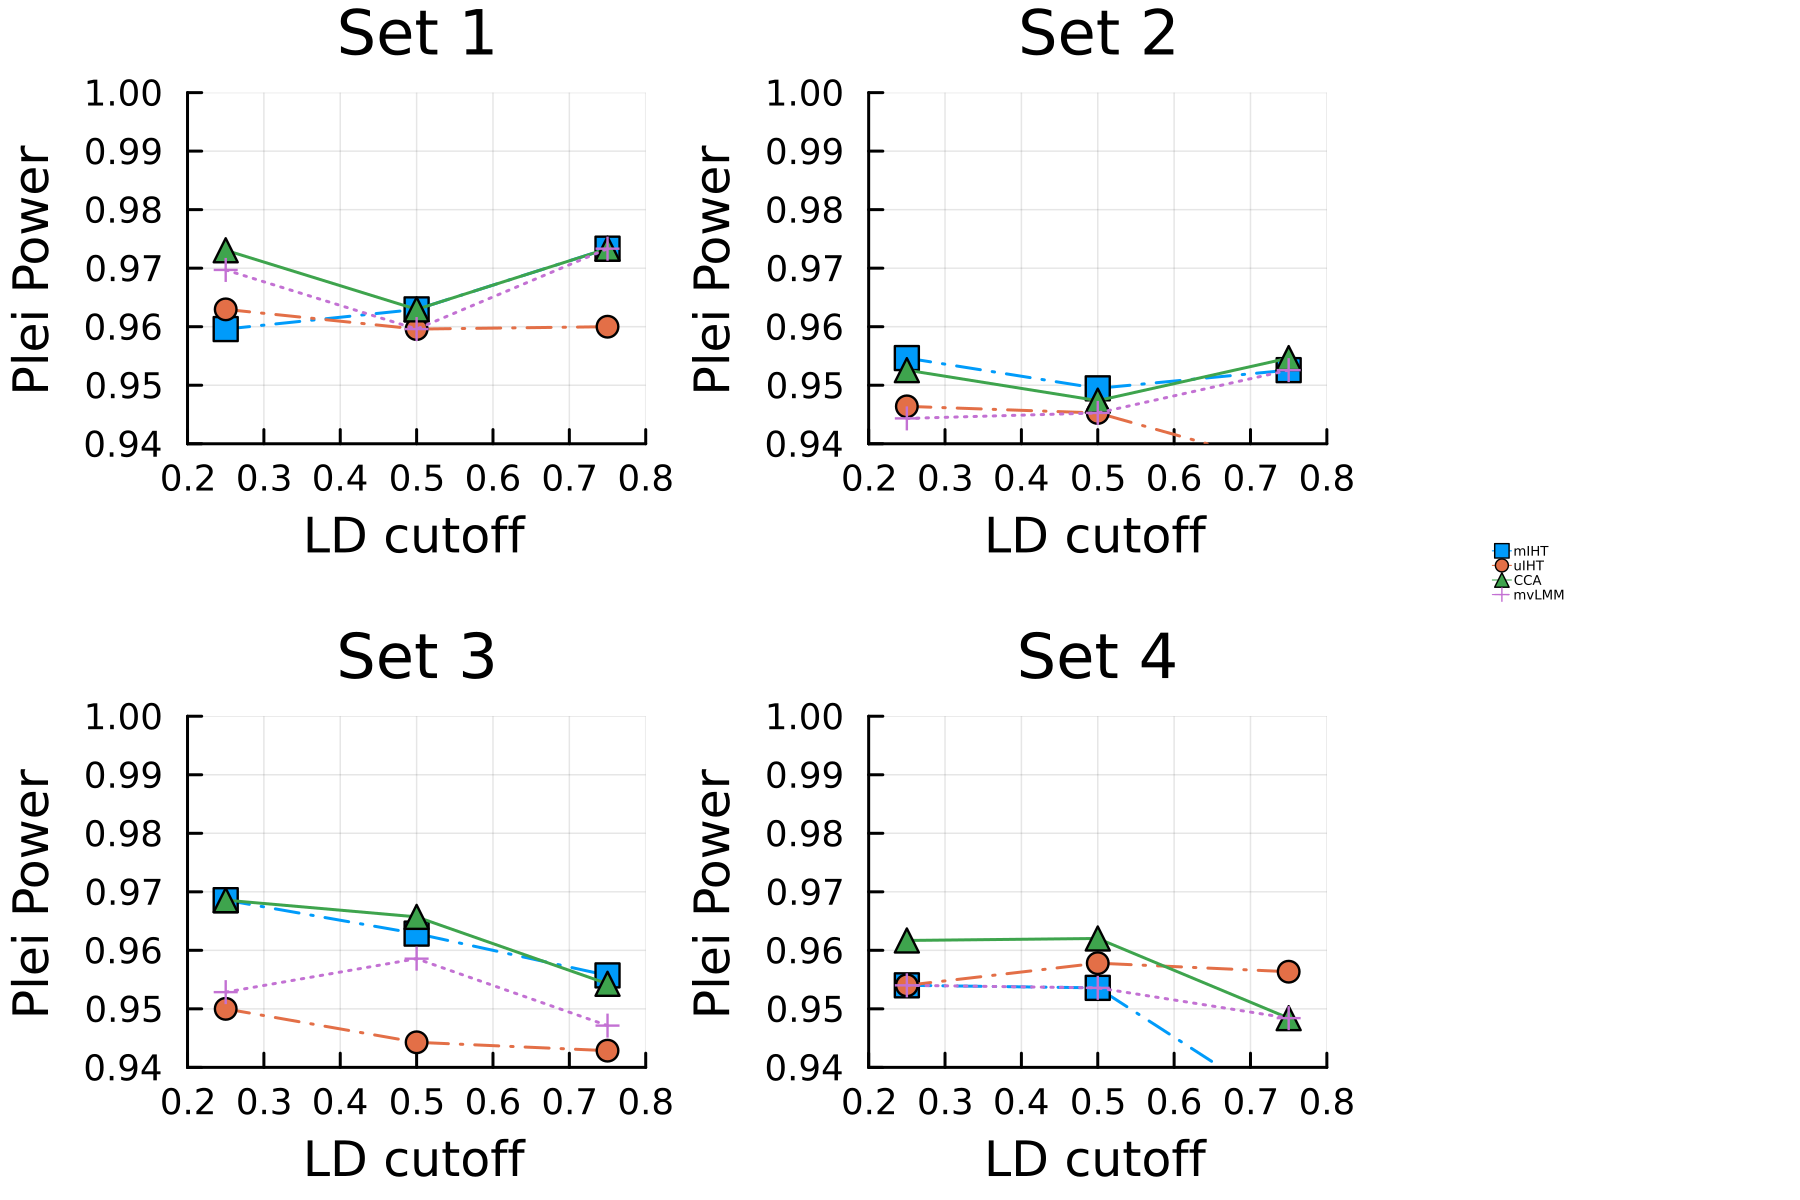

In [6]:
plts = []
LDs = collect(0.25:0.25:0.75)
set_1_and_2_args = (xlim=(0.2, 0.8), ylim=(0.94, 1), 
    legend=false, ylabel="Plei Power", xlabel="LD cutoff", 
    bottommargin=5Plots.mm)
set_3_and_4_args = (xlim=(0.2, 0.8), ylim=(0.94, 1),
    legend=false, ylabel="Plei Power", xlabel="LD cutoff")
for set in 1:4
    mIHT_time, mIHT_plei_power, mIHT_indp_power, mIHT_FP, mIHT_FPR = 
        Float64[], Float64[], Float64[], Float64[], Float64[]
    uIHT_time, uIHT_plei_power, uIHT_indp_power, uIHT_FP, uIHT_FPR = 
        Float64[], Float64[], Float64[], Float64[], Float64[]
    mvPLINK_time, mvPLINK_plei_power, mvPLINK_indp_power, mvPLINK_FP, 
        mvPLINK_FPR, mvPLINK_λ = Float64[], Float64[], Float64[], Float64[], Float64[], Float64[]
    gemma_time, gemma_plei_power, gemma_indp_power, gemma_FP, gemma_FPR, gemma_λ = 
        Float64[], Float64[], Float64[], Float64[], Float64[], Float64[]

    for ld in LDs
        # first obtain mean for current LD
        mIHT_time_mean, mIHT_plei_TP_mean, mIHT_indp_TP_mean, mIHT_FP_mean, 
            uIHT_time_mean, uIHT_plei_TP_mean, uIHT_indp_TP_mean, uIHT_FP_mean, 
            mvPLINK_time_mean, mvPLINK_plei_TP_mean, mvPLINK_indp_TP_mean, mvPLINK_FP_mean, 
            gemma_time_mean, gemma_plei_TP_mean, gemma_indp_TP_mean, gemma_FP_mean = 
            summary_set(set, ld, verbose=false)

        # save the mean values
        push!(mIHT_time, mIHT_time_mean)
        push!(mIHT_plei_power, mIHT_plei_TP_mean)
        push!(mIHT_indp_power, mIHT_indp_TP_mean)
        push!(mIHT_FP, mIHT_FP_mean)

        push!(uIHT_time, uIHT_time_mean)
        push!(uIHT_plei_power, uIHT_plei_TP_mean)
        push!(uIHT_indp_power, uIHT_indp_TP_mean)
        push!(uIHT_FP, uIHT_FP_mean)

        push!(mvPLINK_time, mvPLINK_time_mean)
        push!(mvPLINK_plei_power, mvPLINK_plei_TP_mean)
        push!(mvPLINK_indp_power, mvPLINK_indp_TP_mean)
        push!(mvPLINK_FP, mvPLINK_FP_mean)

        push!(gemma_time, gemma_time_mean)
        push!(gemma_plei_power, gemma_plei_TP_mean)
        push!(gemma_indp_power, gemma_indp_TP_mean)
        push!(gemma_FP, gemma_FP_mean)
    end

    plei_plt = set ≤ 2 ? 
        plot(;title="Set $set", set_1_and_2_args...) : 
        plot(;title="Set $set", set_3_and_4_args...)
    plot!(plei_plt, LDs, mIHT_plei_power, label="mIHT", markershape=:rect, linestyle=:dashdot)
    plot!(plei_plt, LDs, uIHT_plei_power, label="uIHT", markershape=:circle, linestyle=:dashdot)
    plot!(plei_plt, LDs, mvPLINK_plei_power, label="CCA", markershape=:utriangle, linestyle=:solid)
    plot!(plei_plt, LDs, gemma_plei_power, label="mvLMM", markershape=:cross, linestyle=:dot)
    push!(plts, plei_plt)
end

# make separate plot for legend
n = 4
colors = palette(:default)[1:n]'
labels = ["mIHT" "uIHT" "CCA" "mvLMM"]
shapes = [:rect :circle :utriangle :cross]
lstyles = [:dashdot :dashdot :solid :dot]
legend_plt = plot((-n:-1)',(-n:-1)', lims=(0,1), legendfontsize=3, legend=:left,
    fg_color_legend = nothing, label=labels, fc=colors, frame=:none, 
    markershapes=shapes, linestyle=lstyles)

# create 2x2 and legend layout
l = @layout [grid(2,2) a{0.2w}]
plot(plts..., legend_plt, layout=l, dpi=300)

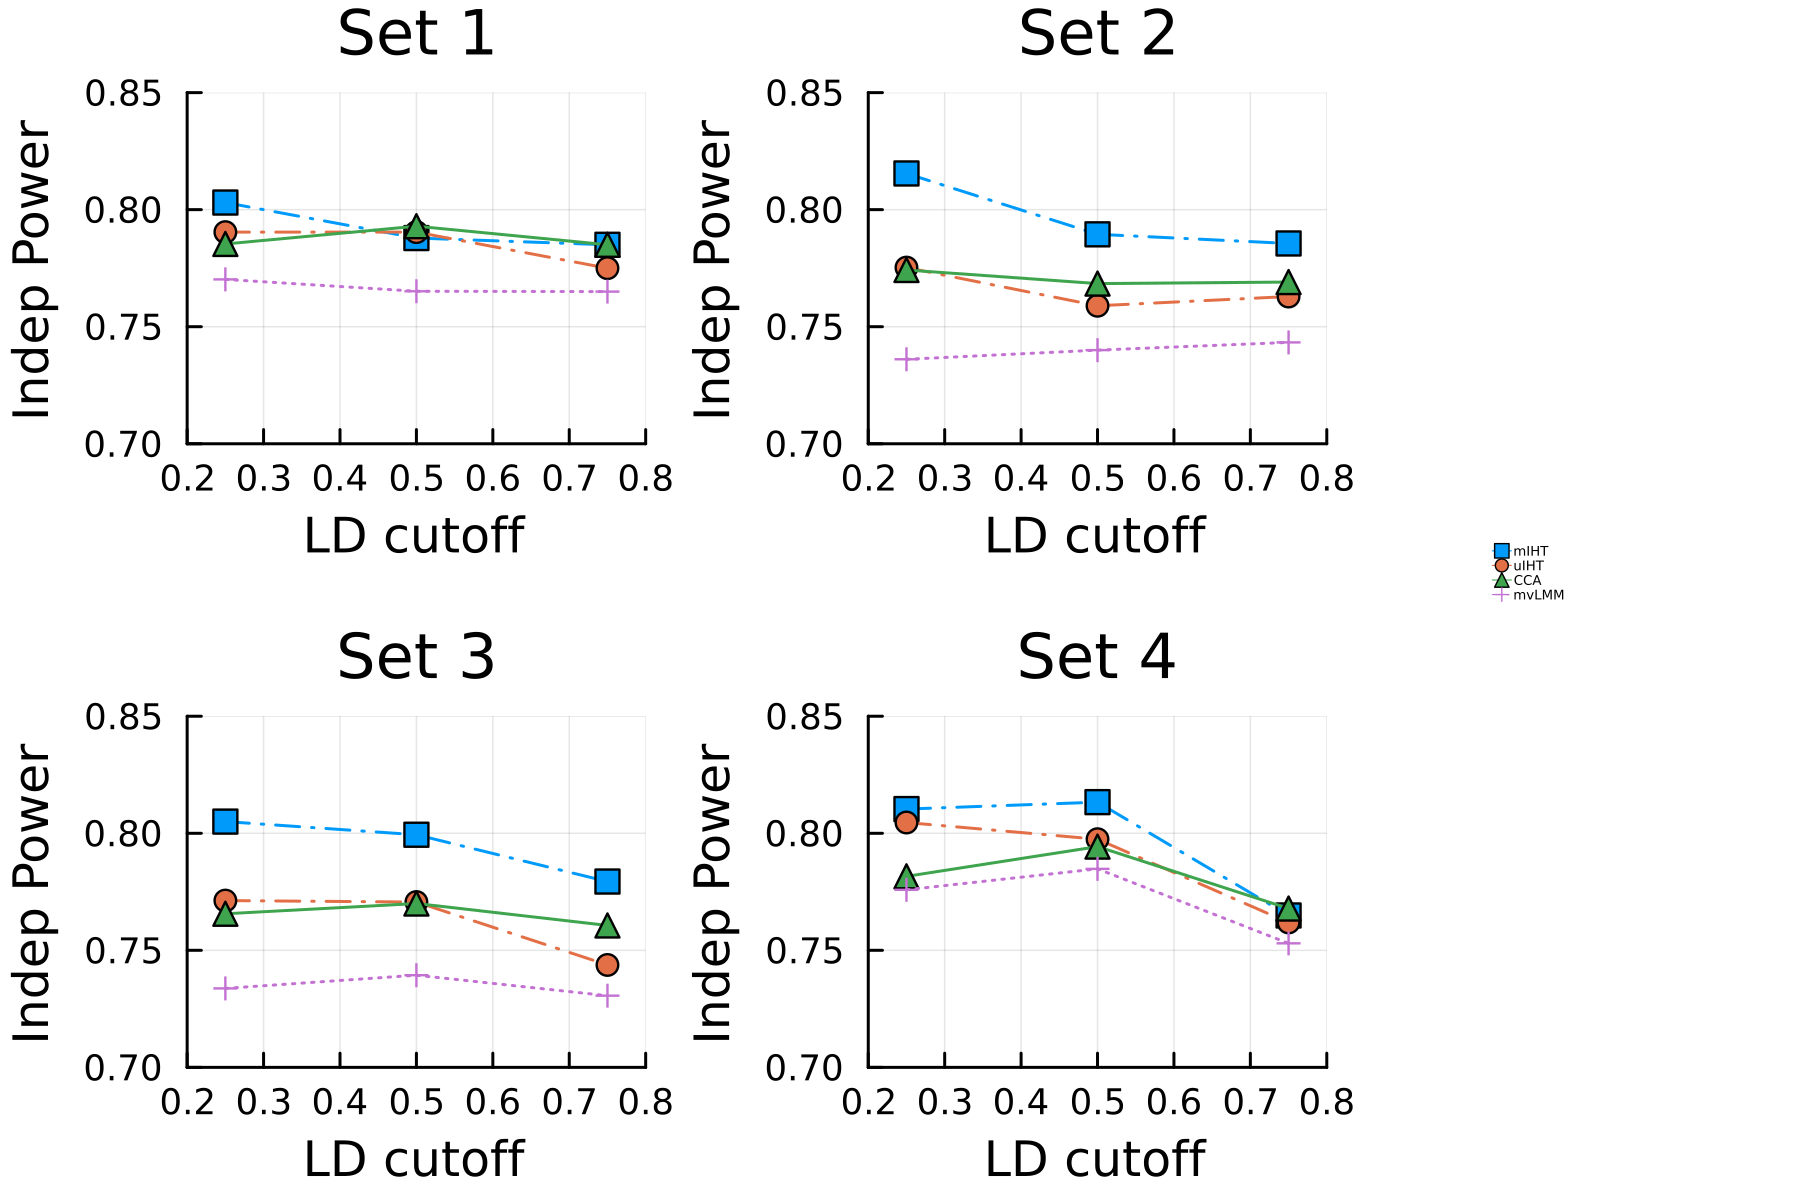

In [7]:
plts = []
LDs = collect(0.25:0.25:0.75)
set_1_and_2_args = (xlim=(0.2, 0.8), ylim=(0.7, 0.85), 
    legend=false, ylabel="Indep Power", xlabel="LD cutoff", 
    bottommargin=5Plots.mm)
set_3_and_4_args = (xlim=(0.2, 0.8), ylim=(0.7, 0.85),
    legend=false, ylabel="Indep Power", xlabel="LD cutoff")
for set in 1:4
    mIHT_time, mIHT_plei_power, mIHT_indp_power, mIHT_FP, mIHT_FPR = 
        Float64[], Float64[], Float64[], Float64[], Float64[]
    uIHT_time, uIHT_plei_power, uIHT_indp_power, uIHT_FP, uIHT_FPR = 
        Float64[], Float64[], Float64[], Float64[], Float64[]
    mvPLINK_time, mvPLINK_plei_power, mvPLINK_indp_power, mvPLINK_FP, 
        mvPLINK_FPR, mvPLINK_λ = Float64[], Float64[], Float64[], Float64[], Float64[], Float64[]
    gemma_time, gemma_plei_power, gemma_indp_power, gemma_FP, gemma_FPR, gemma_λ = 
        Float64[], Float64[], Float64[], Float64[], Float64[], Float64[]

    for ld in LDs
        # first obtain mean for current LD
        mIHT_time_mean, mIHT_plei_TP_mean, mIHT_indp_TP_mean, mIHT_FP_mean, 
            uIHT_time_mean, uIHT_plei_TP_mean, uIHT_indp_TP_mean, uIHT_FP_mean, 
            mvPLINK_time_mean, mvPLINK_plei_TP_mean, mvPLINK_indp_TP_mean, mvPLINK_FP_mean, 
            gemma_time_mean, gemma_plei_TP_mean, gemma_indp_TP_mean, gemma_FP_mean = 
            summary_set(set, ld, verbose=false)

        # save the mean values
        push!(mIHT_time, mIHT_time_mean)
        push!(mIHT_plei_power, mIHT_plei_TP_mean)
        push!(mIHT_indp_power, mIHT_indp_TP_mean)
        push!(mIHT_FP, mIHT_FP_mean)

        push!(uIHT_time, uIHT_time_mean)
        push!(uIHT_plei_power, uIHT_plei_TP_mean)
        push!(uIHT_indp_power, uIHT_indp_TP_mean)
        push!(uIHT_FP, uIHT_FP_mean)

        push!(mvPLINK_time, mvPLINK_time_mean)
        push!(mvPLINK_plei_power, mvPLINK_plei_TP_mean)
        push!(mvPLINK_indp_power, mvPLINK_indp_TP_mean)
        push!(mvPLINK_FP, mvPLINK_FP_mean)

        push!(gemma_time, gemma_time_mean)
        push!(gemma_plei_power, gemma_plei_TP_mean)
        push!(gemma_indp_power, gemma_indp_TP_mean)
        push!(gemma_FP, gemma_FP_mean)
    end

    indp_plt = set ≤ 2 ? 
        plot(;title="Set $set", set_1_and_2_args...) : 
        plot(;title="Set $set", set_3_and_4_args...)
    plot!(indp_plt, LDs, mIHT_indp_power, label="mIHT", markershape=:rect, linestyle=:dashdot)
    plot!(indp_plt, LDs, uIHT_indp_power, label="uIHT", markershape=:circle, linestyle=:dashdot)
    plot!(indp_plt, LDs, mvPLINK_indp_power, label="CCA", markershape=:utriangle, linestyle=:solid)
    plot!(indp_plt, LDs, gemma_indp_power, label="mvLMM", markershape=:cross, linestyle=:dot)
    push!(plts, indp_plt)
end

# make separate plot for legend
n = 4
colors = palette(:default)[1:n]'
labels = ["mIHT" "uIHT" "CCA" "mvLMM"]
shapes = [:rect :circle :utriangle :cross]
lstyles = [:dashdot :dashdot :solid :dot]
legend_plt = plot((-n:-1)',(-n:-1)', lims=(0,1), legendfontsize=3, legend=:left,
    fg_color_legend = nothing, label=labels, fc=colors, frame=:none, 
    markershapes=shapes, linestyle=lstyles)

# create 2x2 and legend layout
l = @layout [grid(2,2) a{0.2w}]
plot(plts..., legend_plt, layout=l, dpi=300)